# CMB CONVERGENCE ANGULAR POWER SPECTRA

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.5, Ob0=0.0483, Om0= 0.3174653243323745)

## 1. Matter power spectra

In [5]:
import sys
sys.path.append("../unequalpy")
from matter import matter_power_spectrum_1loop as P1loop
from matter import matter_unequal_time_power_spectrum as Puetc
from approximation import geometric_approx as Pgeom
from approximation import midpoint_approx as Pmid

* Linear power spectra

In [6]:
import camb

In [7]:
nz = 100

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)

results = camb.get_background(pars)
xs = results.conformal_time(0) - results.tau_maxvis
x = np.linspace(0, xs, nz)
z = results.redshift_at_comoving_radial_distance(x)
k = np.logspace(-5, 3, 1024)

kh = k/(pars.H0/100)
pars.set_matter_power(redshifts=z, kmax=2*k[-1], nonlinear=True)
results = camb.get_results(pars)
kh, z, p = results.get_matter_power_spectrum(minkh=kh[0], maxkh=kh[-1], npoints=len(kh))

Note: redshifts have been re-sorted (earliest first)


In [8]:
pars.set_for_lmax(50000, lens_potential_accuracy=2)
pars.min_l = 1
results = camb.get_results(pars)
cl_camb = results.get_lens_potential_cls(50000)[:,0]

In [9]:
np.allclose(kh*(pars.H0/100), k)

True

* Geometric approximation

In [10]:
pgeom = Pgeom(p)

## 2. The correlation function

In [11]:
import corfu

In [12]:
r_limb, xi_limb = corfu.ptoxi(k, p, q=0.432, limber=True)
r_geom, xi_geom = corfu.ptoxi(k, pgeom, q=0.737)

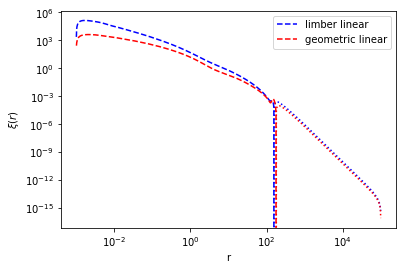

In [13]:
plt.loglog(r_limb, +xi_limb[0], '--b', label='limber linear')
plt.loglog(r_limb, -xi_limb[0], ':b')
plt.loglog(r_geom, +xi_geom[0,0], '--r', label='geometric linear')
plt.loglog(r_geom, -xi_geom[0,0], ':r')

plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\xi(r)$')
plt.show()

## 3. Lensing filters

In [14]:
from lens_filter import lensing_efficiency_cmb, filter_convergence

In [15]:
chi = np.linspace(0., xs, 1200)
zchi = results.redshift_at_comoving_radial_distance(chi)

* Lensing efficiency

In [16]:
q = lensing_efficiency_cmb(chi, xs)

* Convergence

In [17]:
f = filter_convergence(chi, zchi, q, cosmo)

## 4. Angular correlation function

* Convergence

In [18]:
theta = np.logspace(-3, np.log10(np.pi), 64)

In [19]:
w_limb = corfu.eqt(theta, (chi, f*f), (x, r_limb, xi_limb))
w_geom = corfu.uneqt(theta, (chi, f), (chi, f), (x, x, r_geom, xi_geom))

In [20]:
w_camb = corfu.cltow(cl_camb, theta)

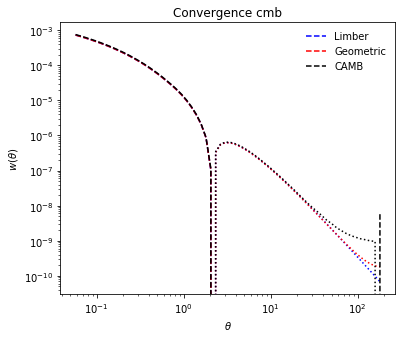

In [21]:
plt.figure(figsize=(6, 5))
plt.loglog(np.degrees(theta), +w_limb, '--b', label='Limber')
plt.loglog(np.degrees(theta), -w_limb, ':b')
plt.loglog(np.degrees(theta), +w_geom, '--r', label='Geometric')
plt.loglog(np.degrees(theta), -w_geom, ':r')
plt.loglog(np.degrees(theta), +0.5*w_camb, '--k', label='CAMB')
plt.loglog(np.degrees(theta), -0.5*w_camb, ':k')


plt.legend(frameon=False)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$w(\theta)$')
plt.title('Convergence cmb')

# plt.savefig('plots/w_cmb.pdf')
plt.show()

## 5. Angular power spectra

* Convergence

In [22]:
l_limb, cl_limb = corfu.wtocl(theta, w_limb, lmax=2000)
l_geom, cl_geom = corfu.wtocl(theta, w_geom, lmax=2000)

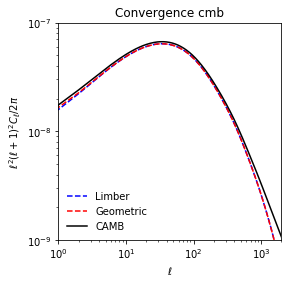

In [23]:
plt.figure(figsize=(4, 4))
plt.loglog(cl_limb, '--b', label='Limber')
plt.loglog(cl_geom, '--r', label='Geometric')
plt.loglog(0.5*cl_camb, 'k', label = 'CAMB')
plt.xlim(1, 1e3)
plt.ylim(1e-9, 1e-7)

plt.legend(frameon=False)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2(\ell+1)^2C_\ell/2\pi$')
plt.xlim([1,2000])
plt.title('Convergence cmb')

# plt.savefig('plots/cl_cmb.pdf')
plt.show()